<a href="https://colab.research.google.com/github/RAVIKUMARBALIJA/explainerdashboard/blob/main/CycleGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.layers import Conv2D,Dense,UpSampling2D,Concatenate,Reshape,Flatten,Dropout,Input,Activation,LeakyReLU

In [34]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential,Model

In [35]:
from PIL import Image

In [36]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-l64ydtty
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-l64ydtty
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=7916cc18eddb60f35162edf6ba5ad65cc298ac3d1e3b5496b4d3680bb4b5b57b
  Stored in directory: /tmp/pip-ephem-wheel-cache-hacfsp7h/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [37]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [38]:
def downsample(layer_input,filters,f_size=4):
  d=Conv2D(filters=filters,kernel_size=f_size,padding='same',strides=2)(layer_input)
  d=InstanceNormalization(axis=-1,center=False,scale=False)(d)
  d=Activation(tf.nn.leaky_relu)(d)
  return d

In [39]:
def upsample(layer_input,skip_input,filters,f_size=4,dropout_rate=0):
  u=UpSampling2D(size=2)(layer_input)
  u=Conv2D(filters=filters,kernel_size=f_size,padding='same',strides=1)(u)
  u=InstanceNormalization(axis=-1,center=False,scale=False)(u)
  u=Activation(tf.nn.leaky_relu)(u)
  if dropout_rate:
    u=Dropout(rate=dropout_rate)(u)
  u=Concatenate()([u,skip_input])
  return u

In [40]:
image_shape=(128,128,3)
gen_filters=32
channels=3
disc_filters=32

In [41]:
def build_generator():
  input=Input(image_shape)
  d1=downsample(input,gen_filters)
  d2=downsample(d1,gen_filters*2)
  d3=downsample(d2,gen_filters*4)
  d4=downsample(d3,gen_filters*8)
  u1=upsample(d4,d3,filters=gen_filters*4)
  u2=upsample(u1,d2,filters=gen_filters*2)
  u3=upsample(u2,d1,filters=gen_filters)
  u4=UpSampling2D(size=2)(u3)
  output=Conv2D(filters=channels,kernel_size=4,padding='same',strides=1,activation=tf.nn.tanh)(u4)
  gen_model=Model(input,output)
  return gen_model

In [42]:
def conv2d(layer_input,filters,kernel_size=4,strides=2,norm=True):
  y=Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(layer_input)
  if norm:
    y=InstanceNormalization()(y)
  y=LeakyReLU(0.2)(y)
  return y


In [43]:
def build_discriminator():
  img=Input(image_shape)
  y=conv2d(img,filters=disc_filters,strides=2,norm=False)
  y=conv2d(y,filters=disc_filters*2,strides=2)
  y=conv2d(y,filters=disc_filters*4,strides=2)
  y=conv2d(y,filters=disc_filters*8,strides=1)
  disc_output=Conv2D(1, kernel_size=4, strides=1, padding='same')(y) ##original Conv2D layer
  disc_model=Model(img,disc_output)
  return disc_model

In [44]:
def build_cyclegan():
  d_A=build_discriminator()
  d_B=build_discriminator()

  d_A.compile(optimizer=Adam(),loss='mse',metrics=['accuracy'])
  d_B.compile(optimizer=Adam(),loss='mse',metrics=['accuracy'])

  g_AB = build_generator()
  g_BA = build_generator()

  d_A.trainable=False
  d_B.trainable=False
  img_A=Input(shape=image_shape)
  img_B=Input(shape=image_shape)

  fake_A=g_BA(img_B)
  fake_B=g_AB(img_A)

  valid_A=d_A(fake_A)
  valid_B=d_B(fake_B)

  reconstr_A=g_BA(fake_B)
  reconstr_B=g_AB(fake_A)

  img_A_id=g_BA(img_A)
  img_B_id=g_AB(img_B)

  gan_combined_Model=Model(inputs=[img_A,img_B],outputs=[valid_A,valid_B,reconstr_A,reconstr_B,img_A_id,img_B_id])

  gan_combined_Model.compile(optimizer=Adam(),loss=['mse','mse','mae','mae','mae','mae'],\
                       loss_weights=[lambda_validation,lambda_validation,lambda_reconstr,lambda_reconstr,lambda_id,lambda_id])
  
  d_A.trainable=True
  d_B.trainable=True

  return gan_combined_Model,d_A,g_AB

In [45]:
#loss weights
lambda_validation = 1
lambda_reconstr = 10
lambda_id = 2

In [46]:
cycle_gan,discriminator,generator=build_cyclegan()

In [47]:
def visualize_model(model_obj):
  model_obj.summary()
  model_Image=tf.keras.utils.plot_model(
    model_obj,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
   )
  return model_Image

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_8 (Functional)            (None, 128, 128, 3)  1545411     input_12[0][0]                   
                                                                 model_7[0][0]                    
                                                                 input_11[0][0]                   
____________________________________________________________________________________________

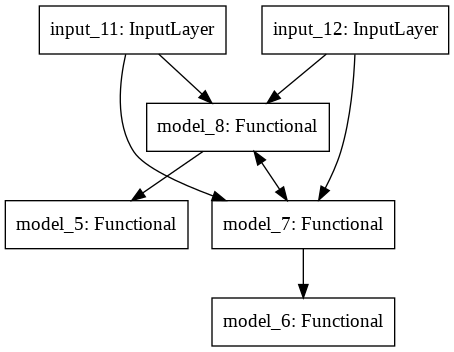

In [48]:
visualize_model(cycle_gan)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 32)        1568      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 64)        32832     
_________________________________________________________________
instance_normalization_20 (I (None, 32, 32, 64)        2         
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 128)       1312

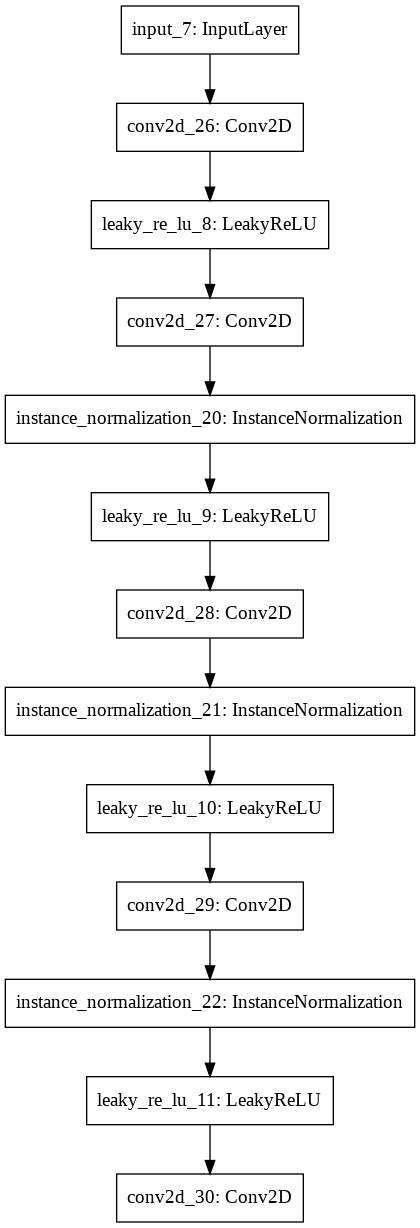

In [49]:
visualize_model(discriminator)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 64, 64, 32)   1568        input_9[0][0]                    
__________________________________________________________________________________________________
instance_normalization_26 (Inst (None, 64, 64, 32)   0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_14 (Activation)      (None, 64, 64, 32)   0           instance_normalization_26[0][0]  
____________________________________________________________________________________________

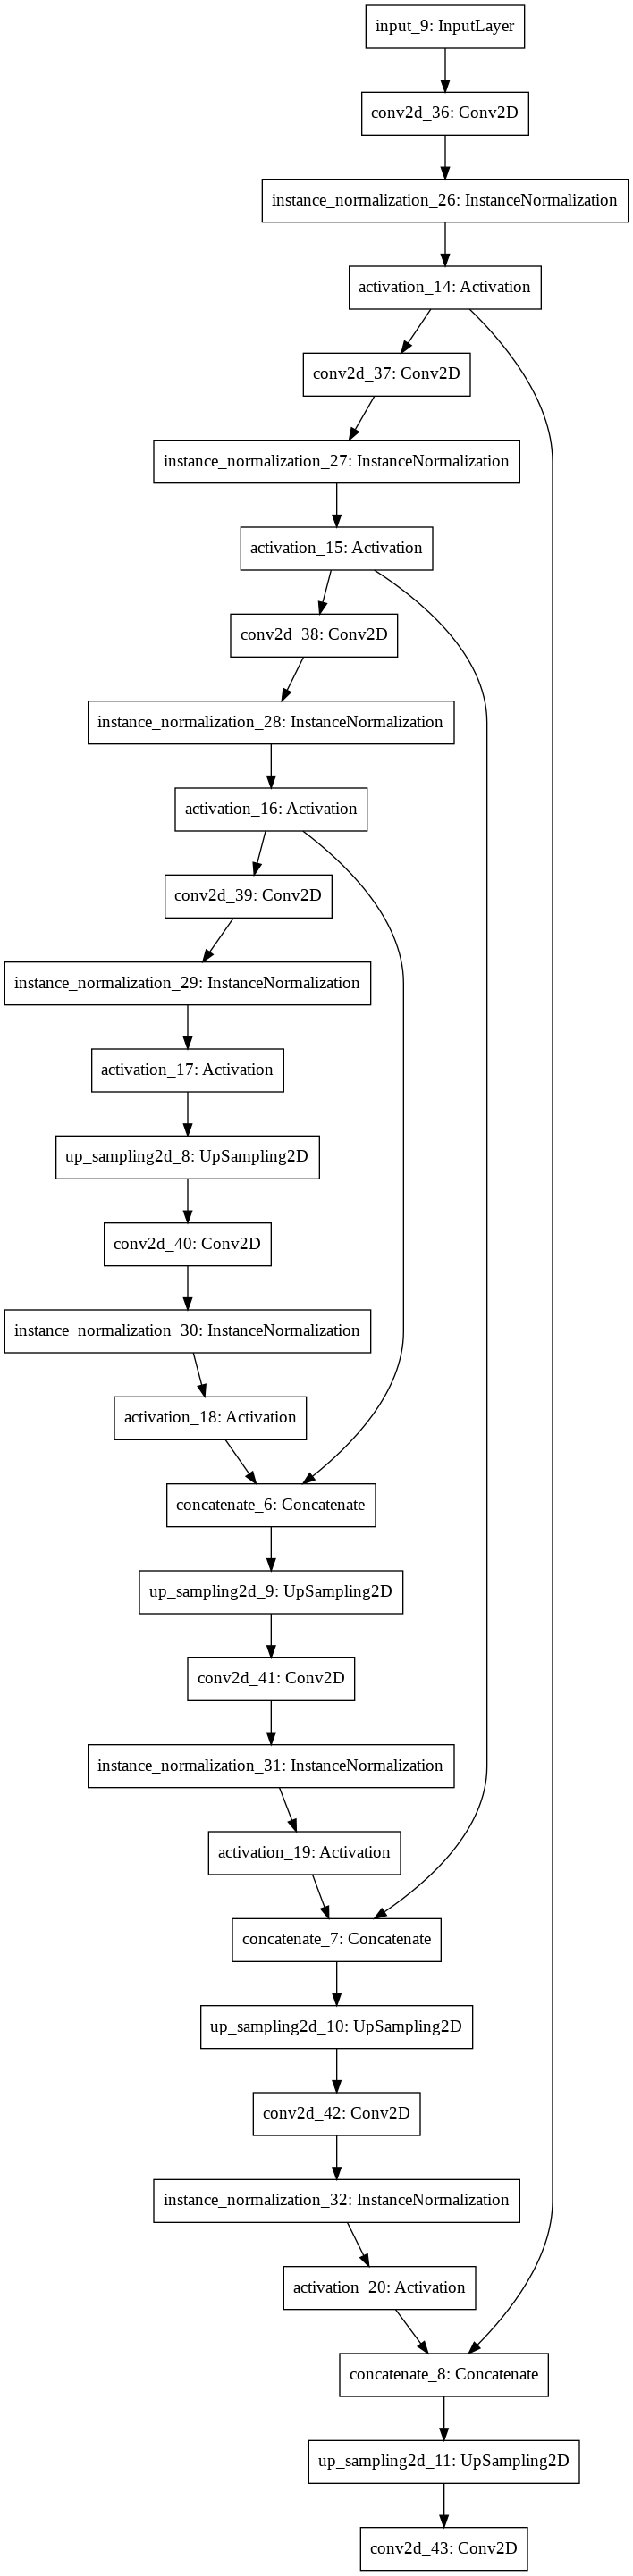

In [50]:
visualize_model(generator)

In [51]:
batch_size=1
patch=int(image_shape[0]/2**3) #128/8
discriminator_patch=(patch,patch,1) #(16,16,1)
epochs=50

In [52]:
valid=np.ones((batch_size,)+discriminator_patch)
fake=np.zeros((batch_size,)+discriminator_patch)

In [53]:
#np.ones((batch_size,)+discriminator_patch).shape

In [54]:
from zipfile import ZipFile
import os
import sys

In [66]:
for file in os.listdir(os.path.join(os.getcwd(),'sample_data')):
  print()

TypeError: ignored

In [67]:
os.path.join(os.getcwd(),'sample_data')

'/content/sample_data'

In [68]:
path='/content/sample_data/apple2orange.zip'
zipref=ZipFile(path)
zipref.extractall('/content/sample_data/')
zipref.close()

BadZipFile: ignored

In [69]:
from keras.preprocessing.image import ImageDataGenerator